- In this notebook we compute popular maesure Risks such as Value at Risk(VaR) and Conditional VaR(CVaR), using historical stock data, parametric fitting and finally Monte Carlo Simulations. We extract stock data using the yfinance package.
- For the first part, we ignore asset correlations, and fit a univariate distribution to the aggregated portfolio returns. In the second part we use multivariate distributions.
- The goals are:
    - Fit historical data to normal and t distrib'utions, and compare their risk metric predictions.
    - Compare the effect of asset correlations by fitting the data to a multivariate distribution, including:
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-06-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                                AAPL        MSFT       GOOG      NVDA  \
Date                                                                    
2020-01-02 00:00:00-05:00  72.620834  153.042282  67.964508  5.971746   
2020-01-03 00:00:00-05:00  71.914810  151.136627  67.630989  5.876163   
2020-01-06 00:00:00-05:00  72.487839  151.527344  69.298576  5.900805   
2020-01-07 00:00:00-05:00  72.146942  150.145737  69.255341  5.972246   
2020-01-08 00:00:00-05:00  73.307518  152.537323  69.801094  5.983447   

                                AMZN  
Date                                  
2020-01-02 00:00:00-05:00  94.900497  
2020-01-03 00:00:00-05:00  93.748497  
2020-01-06 00:00:00-05:00  95.143997  
2020-01-07 00:00:00-05:00  95.343002  
2020-01-08 00:00:00-05:00  94.598503  


In [3]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2024-05-24 00:00:00-04:00,189.095657,426.887085,175.288086,106.426643,180.750000
2024-05-28 00:00:00-04:00,189.105606,427.045837,176.968079,113.855675,182.149994
2024-05-29 00:00:00-04:00,189.404205,425.904602,176.351746,114.779305,182.020004
2024-05-30 00:00:00-04:00,190.399567,411.514954,172.534439,110.456024,179.320007
2024-05-31 00:00:00-04:00,191.355087,411.971466,172.932053,109.589378,176.440002


In [4]:
data.shape

(1111, 5)

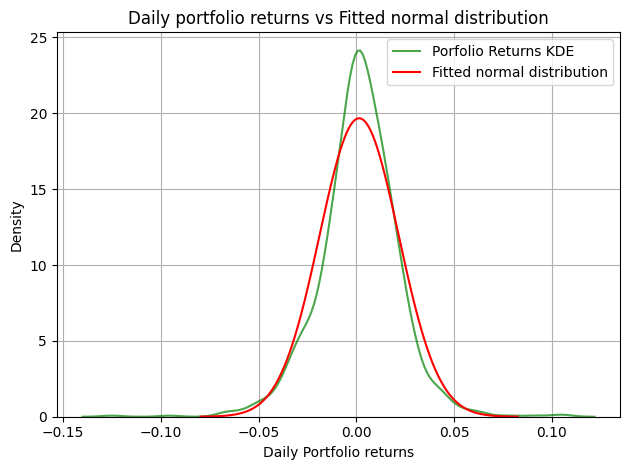

In [5]:
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## It looks like a bad fit, but notice that it fits the tails well. The left tails is what matters to us.

=== Portfolio Risk Metrics with Normal distribution (95% confidence) ===
Historical VaR: -0.0316
Parametric VaR: -0.0319
Monte Carlo VaR: -0.0326
Conditional VaR (CVaR): -0.0452


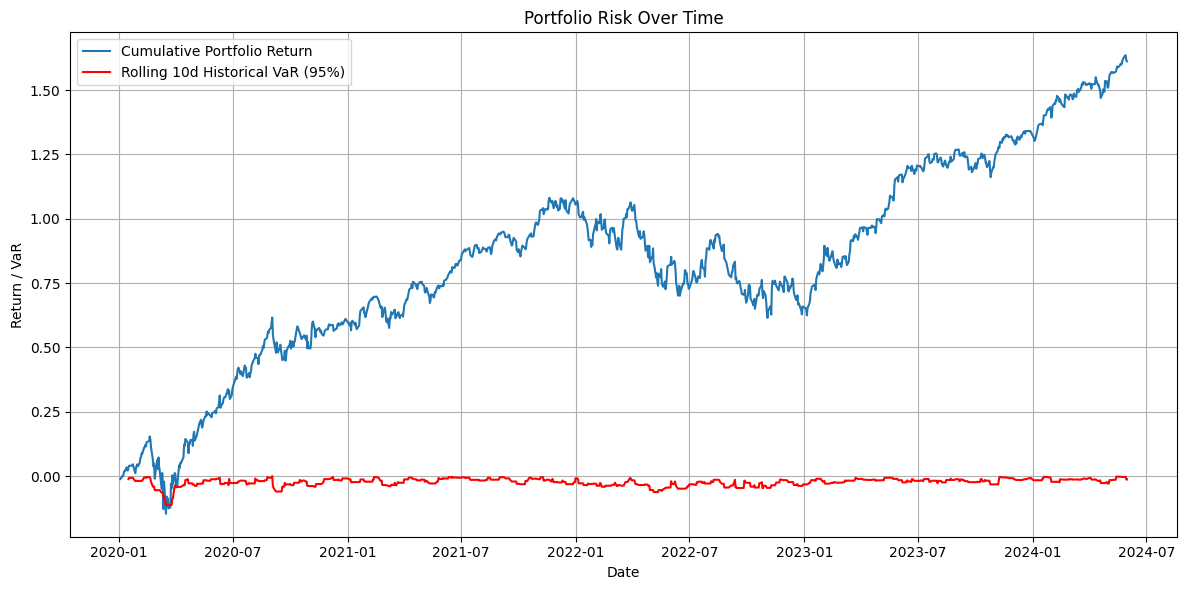

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100) #Note: Historical VaR doesnt depend on the distribution

#  Parametric VaR (Variance-Covariance, assuming normality) 

param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics with Normal distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 10  # 60-day rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)

plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label='Cumulative Portfolio Return')
plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')
plt.title('Portfolio Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Return / VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
returns.min()

AAPL   -0.128647
MSFT   -0.147390
GOOG   -0.111008
NVDA   -0.184521
AMZN   -0.140494
dtype: float64

In [8]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


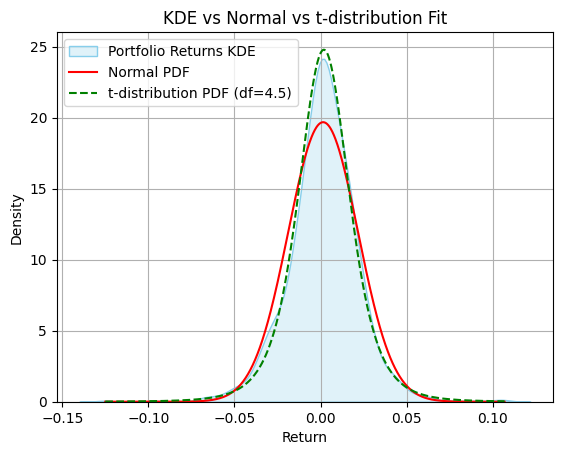

In [10]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')

plt.title("KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## The t-distribution is a much better fit to the aggregate Portfolio returns! Lets recompute everything(except Historical VaR)

In [11]:
#  Parametric VaR (Variance-Covariance, assuming t) 
param_VaR_t = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0296
Monte Carlo VaR_t: -0.0307
Monte Carlo CVaR (95%): -0.0467


## The VaR values are actually slightly higher, but the CVaR is same. It doesnt seem that we have captured any more tail risk. This is because both fits have nearly the same tails

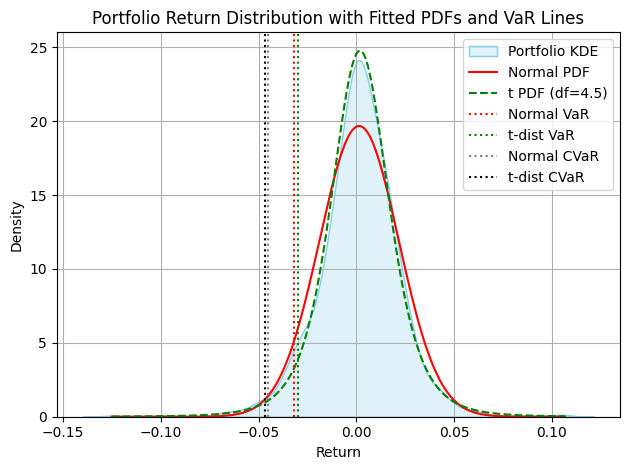

In [12]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR, color='red', linestyle=':', label='Normal VaR')
plt.axvline(param_VaR_t, color='green', linestyle=':', label='t-dist VaR')
plt.axvline(CVaR,color='grey', linestyle=':', label = 'Normal CVaR')
plt.axvline(t_CVaR,color='black', linestyle=':', label = 't-dist CVaR')

plt.title('Portfolio Return Distribution with Fitted PDFs and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

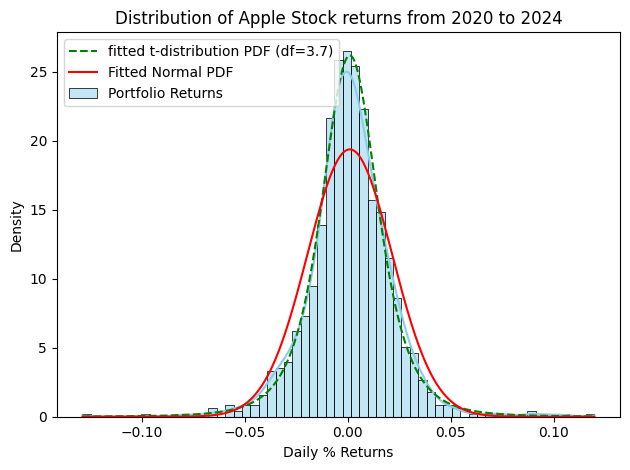

In [21]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f'fitted t-distribution PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Pairplot of Stock Returns')

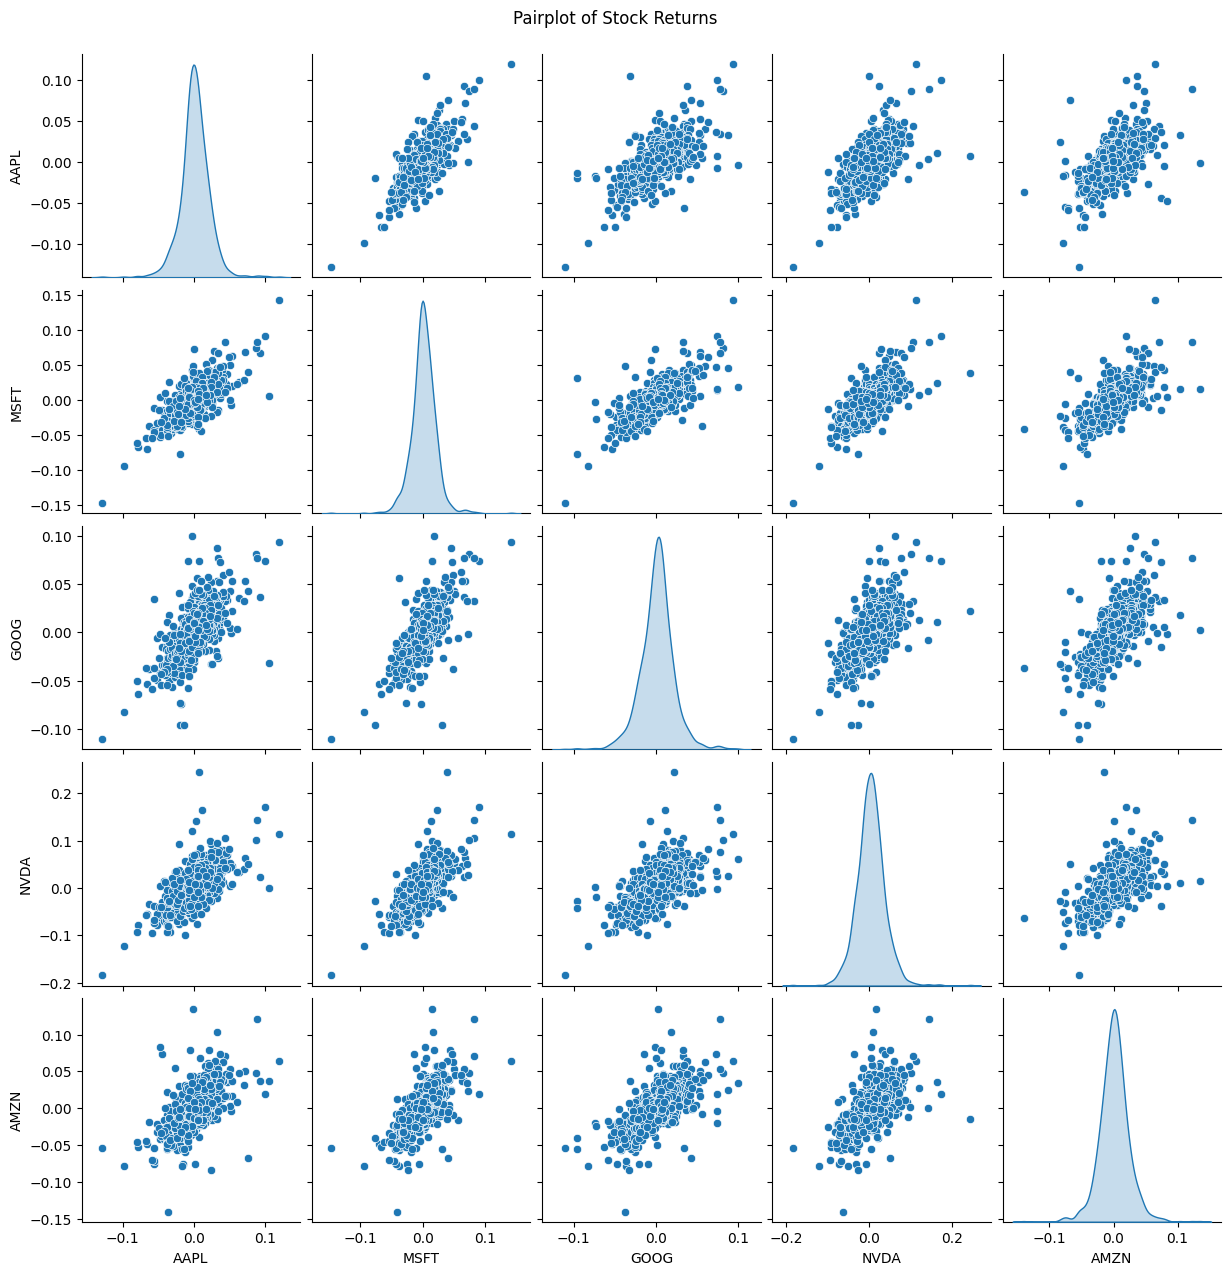

In [17]:
sns.pairplot(returns, diag_kind='kde', markers='o')
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

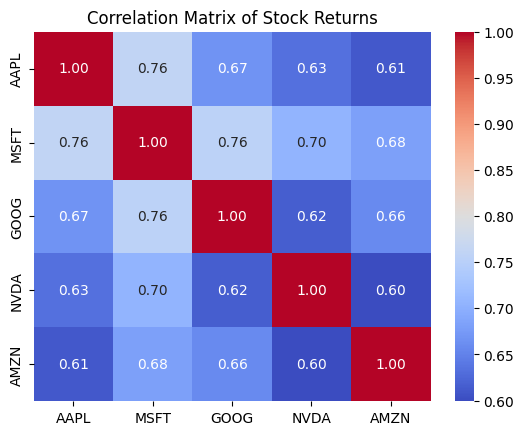

In [18]:
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stock Returns')

In [22]:
import numpy as np

n_samples = 10000
df = 5  # degrees of freedom (low df = fat tails)

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)

# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

# === Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)


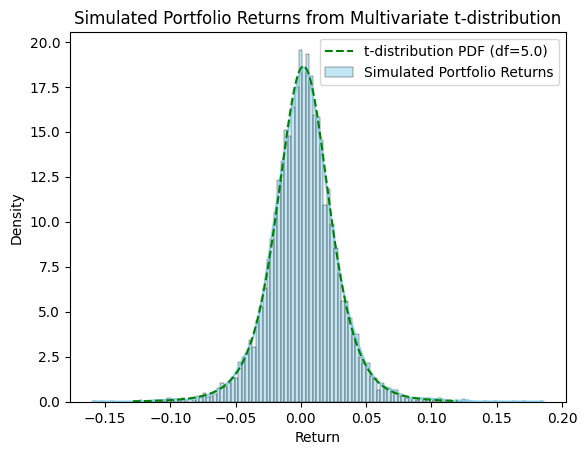

In [32]:
mvt_samples.shape
portfolio_returns_mvt = mvt_samples.dot(weights)
df, loc, scale = t.fit(portfolio_returns_mvt)
sns.histplot(portfolio_returns_mvt, kde=True, stat='density', color='skyblue', label='Simulated Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.title('Simulated Portfolio Returns from Multivariate t-distribution')
plt.xlabel('Return')    
plt.ylabel('Density')
plt.legend()    
plt.show()  

=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_mvt: -0.0391
CVaR_mvt: -0.0558


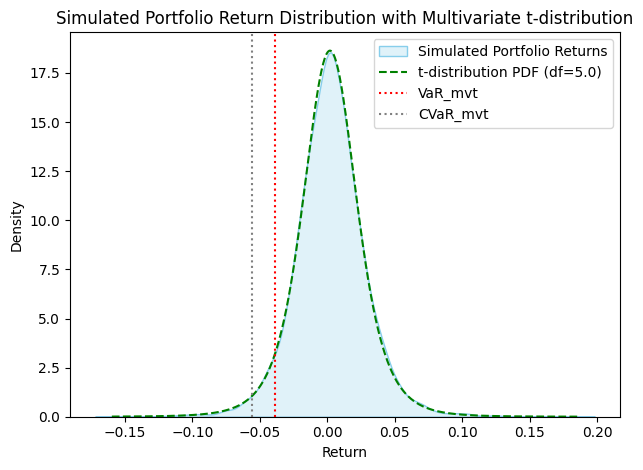

In [34]:
VaR_mvt = np.percentile(portfolio_returns_mvt, (1-confidence_level)*100)
CVaR_mvt = portfolio_returns_mvt[portfolio_returns_mvt <= VaR_mvt].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvt: {VaR_mvt:.4f}")            
print(f"CVaR_mvt: {CVaR_mvt:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_mvt.min(), portfolio_returns_mvt.max(), 1000)
sns.kdeplot(portfolio_returns_mvt, fill=True, color='skyblue', label='Simulated Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvt, color='red', linestyle=':', label='VaR_mvt')
plt.axvline(CVaR_mvt, color='grey', linestyle=':', label='CVaR_mvt')
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Both the VaR and CVaR estimates are much lower when incorportating asset correlations. This is probably due to the fact, that when correlated assets fall together(perhaps during crises), they reduce the expected minimal shortfall.

**Summary:**

**- Analyzed historical returns from a portfolio of large-cap tech stocks and fitted both a normal distribution and a Student’s t-distribution to the portfolio’s daily returns.**

**- The t-distribution provided a visibly better overall fit to the empirical return distribution (as seen from KDE comparison), especially capturing the peak and moderate tails more accurately.**

**- However, both distributions fit the extreme left tail similarly well, which is the region that determines Value at Risk (VaR).**

**- As a result, the VaR estimates at the 95% confidence level were very close between the normal and t-distributions.**

**- Next, we took into account asset correlations by simulating and fitting a multivariate t distribution. We found that the risk metrics were significantly lower, pointing to the fact that asset correlations, which contribute to crises, are crucial for modelling risk.**
